In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, BertConfig, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import fasttext

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.2.1) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/raid/home/akshat21515/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-04-20 22:43:35.451171: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-20 22:43:36.151818: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


<br><br>
<h3>Loading Data</h3>

In [2]:
train_path='./train_file.json' #"/kaggle/input/erc-and-efr/train_file.json"
val_path= './val_file.json' #"/kaggle/input/erc-and-efr/val_file.json"

with open(train_path) as f:
    train_list = json.load(f)

with open(val_path) as f:
    val_list = json.load(f)



val_list,test_list=train_test_split(val_list, test_size=0.1, random_state=42)


train_data=[]
for item in train_list:
    episode = item['episode']
    speakers = item['speakers']
    emotions = item['emotions']
    utterances = item['utterances']
    triggers = item['triggers']
    train_data.append({'utterances':utterances,'emotions':emotions, 'triggers':triggers, 'speakers':speakers})


val_data=[]
for item in val_list:
    episode = item['episode']
    speakers = item['speakers']
    emotions = item['emotions']
    utterances = item['utterances']
    triggers = item['triggers']
    val_data.append({'utterances':utterances,'emotions':emotions, 'triggers':triggers, 'speakers':speakers})


# create test.json
test_data=[]
for item in test_list:
    episode = item['episode']
    speakers = item['speakers']
    emotions = item['emotions']
    utterances = item['utterances']
    triggers = item['triggers']
    item_dict = {
        'episode': episode,
        'speakers': speakers,
        'emotions': emotions,
        'utterances': utterances,
        'triggers': triggers
    }
    test_data.append(item_dict)

json_string = json.dumps(test_data)
with open('./test_file.json', 'w') as f:
    f.write(json_string)

label_map = {'anger':0, 'surprise':1, 'sadness':2, 'neutral':3, 'fear':4, 'joy':5, 'disgust':6}  # Map emotions to labels

<br><br>
<h3>Finding Flips for Task 1 </h3>

In [3]:
file=open('./flipped_utterances.txt','w')
for item in train_list:
    episode = item['episode']
    speakers = item['speakers']
    emotions = item['emotions']
    utterances = item['utterances']
    triggers = item['triggers']
    utterances_of_speaker={}
    flipped_utterances=[]
    
    for i in range (0,len(utterances)): 
        if (speakers[i] not in utterances_of_speaker): utterances_of_speaker[speakers[i]]=[]
        utterances_of_speaker[speakers[i]].append([utterances[i],emotions[i],i,speakers[i]])    
        
    for a in utterances_of_speaker: 
        for b in range(0,len(utterances_of_speaker[a])-1): 
            if (utterances_of_speaker[a][b][1]!=utterances_of_speaker[a][b+1][1]): 
                flipped_utterances.append([utterances_of_speaker[a][b],utterances_of_speaker[a][b+1]])
                
    txt=f'episode={episode}\n'
    for utterances in flipped_utterances: 
        utt1=utterances[0]
        utt2=utterances[1]
        txt+=f'speaker: {utt1[3]}\n'
        txt+=f'utterance1: U{utt1[2]}- {utt1[0]} ---> utterance2: U{utt2[2]}- {utt2[0]}\n'
        txt+=f'emotion1: {utt1[1]} ---> emotion2: {utt2[1]}\n\n'
    txt+='\n\n\n'
    file.write(txt)

<br><br>
<h3>General Pipeline for training and Validation</h3>

In [4]:
def preprocess_for_ERC_Model1(dialogues,emotions,tokenizer,max_len):
     global label_map
     input_ids = []
     attention_masks=[]
     for i in range(len(dialogues)):
          for j in range(len(dialogues[i])):
              window_text = ' [SEP] '.join(dialogues[i][max(0,j-4):j+1])  # Concatenate the current utterance with previous 5 utterances if possible
              encoded_input = tokenizer(window_text, return_tensors='pt',padding='max_length', truncation=True, max_length=max_len)
              input_ids.append(encoded_input['input_ids'].flatten())
              attention_masks.append(encoded_input['attention_mask'].flatten())

     labels = torch.tensor([label_map[emotion] for emotion in emotions])
     return input_ids,attention_masks,labels


def preprocess_for_ERC_Model2(dialogues,emotions):
    
    global label_map 
    # FastText model
    fasttext_model = fasttext.load_model('./Embeddings/cc.en.300.bin') #('/kaggle/input/embeddings/cc.en.300.bin')
    sentence_embeddings = []
    for i in range(len(dialogues)):
        for j in range(len(dialogues[i])):
            sentence=dialogues[i][j] 
            word_embeddings = [fasttext_model.get_word_vector(word) for word in sentence.split()]
            sentence_embedding = np.mean(word_embeddings, axis=0)
            sentence_embeddings.append(torch.tensor(sentence_embedding))
    labels = torch.tensor([label_map[emotion] for emotion in emotions])
    sentence_embeddings=torch.stack(sentence_embeddings)
    return sentence_embeddings,None,labels
  

def preprocess_for_EFR_Model3(dialogues,speakers,triggers,tokenizer,max_len):
     global label_map
     input_ids = []
     attention_masks=[]
     label_triggers=[]
     lens=[]

     for i in range(len(dialogues)):
          last_text_by_a_speaker=-1
          previous_flipped_emotion_text_by_same_speaker=-1
          speaker=speakers[i][-1]
          for j in range(len(dialogues[i])-1,-1,-1):
              if speakers[i][j]==speaker:
                  previous_flipped_emotion_text_by_same_speaker=j
                  break

          curr_input_ids=[]
          curr_attention_masks=[]

          for j in range(len(dialogues[i])):
              window_text = dialogues[i][j]  # Concatenate the current utterance with previous 5 utterances if possible
              encoded_input = tokenizer(window_text, return_tensors='pt',padding='max_length', truncation=True, max_length=max_len)
              lens.append(len(encoded_input['input_ids'].flatten()))
              curr_input_ids.append(encoded_input['input_ids'].flatten())
              curr_attention_masks.append(encoded_input['attention_mask'].flatten())


          for j in range(len(dialogues[i])):
              curr_input_ids[j]=torch.cat((curr_input_ids[j],curr_input_ids[last_text_by_a_speaker],curr_input_ids[previous_flipped_emotion_text_by_same_speaker]),dim=0)
              curr_attention_masks[j]=torch.cat((curr_attention_masks[j],curr_attention_masks[last_text_by_a_speaker],curr_attention_masks[previous_flipped_emotion_text_by_same_speaker]),dim=0)

          input_ids.extend(curr_input_ids)
          attention_masks.extend(curr_attention_masks)
          
          try:
              k=sum(triggers[i])
          except:
                 for a in range(len(triggers[i])):
                     if triggers[i][a]==None: triggers[i][a]=0.0

          label_triggers.extend(triggers[i]) # skip those instances where triggers has None values
     return input_ids,attention_masks,label_triggers



def preprocess_for_EFR_Model4(dialogues,emotions,speakers,triggers):
    global label_map 
    # FastText model
    fasttext_model = fasttext.load_model('./Embeddings/cc.en.300.bin') #('/kaggle/input/embeddings/cc.en.300.bin')
    sentence_embeddings = []
    label_triggers=[]
    for i in range(len(dialogues)):
        last_text_by_a_speaker=-1
        previous_flipped_emotion_text_by_same_speaker=-1
        speaker=speakers[i][-1]
        for j in range(len(dialogues[i])-1,-1,-1):
            if speakers[i][j]==speaker:
                previous_flipped_emotion_text_by_same_speaker=j
                break

        curr_sentence_embeddings=[]
          
        for j in range(len(dialogues[i])):
            sentence=dialogues[i][j] 
            word_embeddings = [fasttext_model.get_word_vector(word) for word in sentence.split()]
            sentence_embedding = np.mean(word_embeddings, axis=0)
            curr_sentence_embeddings.append(torch.tensor(sentence_embedding))
            
            
        for j in range(len(dialogues[i])):
            curr_sentence_embeddings[j]=torch.cat((curr_sentence_embeddings[j],curr_sentence_embeddings[last_text_by_a_speaker],curr_sentence_embeddings[previous_flipped_emotion_text_by_same_speaker]),dim=0)
            

        sentence_embeddings.extend(curr_sentence_embeddings)
        
        try:
            k=sum(triggers[i])
        except:
                for a in range(len(triggers[i])):
                    if triggers[i][a]==None: triggers[i][a]=0.0

        label_triggers.extend(triggers[i]) # skip those instances where triggers has None values
            

    sentence_embeddings=torch.stack(sentence_embeddings)
    return sentence_embeddings,None,label_triggers
  


def preprocess_model(dialogues,emotions,speakers_per_dialogue,triggers,tokenizer,max_len,Type='M1'):
    if Type=='M1' :
         return preprocess_for_ERC_Model1(dialogues,emotions,tokenizer,max_len)

    elif Type=='M2':
          return preprocess_for_ERC_Model2(dialogues,emotions)

    elif Type=='M3':
         return preprocess_for_EFR_Model3(dialogues,speakers_per_dialogue,triggers,tokenizer,max_len)

    elif Type=='M4':
          return preprocess_for_EFR_Model4(dialogues,emotions,speakers_per_dialogue,triggers)


def plot_losses(train_losses,val_losses):
    # Plotting
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')

    plt.title('Loss Plot: Training and Validation Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()



def trainer_and_validator(gpu="F",train_dataloader=None,val_dataloader=None,model=None,criterion=None,optimizer=None,num_epochs=10,checkpoint_dir="",Type='M1'):
      device = torch.device("cuda:3") if gpu == "T" else torch.device("cpu")
      model.to(device)
      os.makedirs(os.path.dirname(checkpoint_dir), exist_ok=True)

      train_losses=[]
      val_losses=[]
      for epoch in range(num_epochs):
          model.train()
          total_train_loss = 0
          predictions = []
          true_labels = []

          cnt=0
          for batch in train_dataloader:
              if Type=='M1':
                  input_ids=batch[0].to(device)
                  attention_masks=batch[1].to(device)
                  labels=batch[2].to(device)
                  optimizer.zero_grad()
                  outputs = model(input_ids=input_ids, attention_mask=attention_masks,labels=labels)
                  loss = outputs.loss
                  total_train_loss += loss.item()
                  _, predicted = torch.max(outputs.logits, 1)
                  predictions.extend(predicted.cpu().numpy())
                  true_labels.extend(labels.cpu().numpy())
                  loss.backward()
                  optimizer.step()

              if Type=='M2':
                  sentence_embeddings=batch[0].to(device)
                  labels=batch[1].to(device)
                  optimizer.zero_grad()
                  outputs = model(sentence_embeddings)
                  loss = criterion(outputs, labels)
                  total_train_loss += loss.item()
                  _, predicted = torch.max(outputs, 1)
                  predictions.extend(predicted.cpu().numpy())
                  true_labels.extend(labels.cpu().numpy())
                  loss.backward()
                  optimizer.step()

              if Type=='M3':
                  input_ids=batch[0].to(device)
                  attention_masks=batch[1].to(device)
                  labels=batch[2].to(device)
                  optimizer.zero_grad()
                  outputs = model(input_ids=input_ids, attention_mask=attention_masks,labels=labels)
                  loss = outputs.loss
                  total_train_loss += loss.item()
                  preds = outputs.logits.squeeze().detach().cpu().numpy()
                  binary_preds = np.where(preds > 0.5, 1, 0)
                  predictions.extend(binary_preds)
                  true_labels.extend(labels.cpu().numpy())
                  loss.backward()
                  optimizer.step()
                 
              if Type=='M4':
                  sentence_embeddings=batch[0].to(device)
                  labels=batch[1].to(device)
                  labels = torch.round(labels).long()
                  optimizer.zero_grad()
                  outputs = model(sentence_embeddings)
                  loss = criterion(outputs, labels)
                  total_train_loss += loss.item()
                  _, predicted = torch.max(outputs, 1)
                  predictions.extend(predicted.cpu().numpy())
                  true_labels.extend(labels.cpu().numpy())
                  loss.backward()
                  optimizer.step()


              cnt+=1
            #   if (cnt%100==0): print(cnt)

          avg_train_loss = total_train_loss / len(train_dataloader)
          train_losses.append(avg_train_loss)
          train_accuracy = accuracy_score(true_labels, predictions)
          train_f1 = f1_score(true_labels, predictions, average='weighted')




          model.eval()
          total_val_loss=0
          predictions = []
          true_labels = []
          with torch.no_grad():
              for batch in val_dataloader:
                  if Type=='M1':
                      input_ids=batch[0].to(device)
                      attention_masks=batch[1].to(device)
                      labels=batch[2].to(device)
                      outputs = model(input_ids=input_ids, attention_mask=attention_masks,labels=labels)
                      loss = outputs.loss
                      total_val_loss += loss.item()
                      _, predicted = torch.max(outputs.logits, 1)
                      predictions.extend(predicted.cpu().numpy())
                      true_labels.extend(labels.cpu().numpy())

                  if Type=='M2':
                        sentence_embeddings=batch[0].to(device)
                        labels=batch[1].to(device)
                        outputs = model(sentence_embeddings)
                        loss = criterion(outputs, labels)
                        total_val_loss += loss.item()
                        _, predicted = torch.max(outputs, 1)
                        predictions.extend(predicted.cpu().numpy())
                        true_labels.extend(labels.cpu().numpy())
                


                  if Type=='M3':
                        input_ids=batch[0].to(device)
                        attention_masks=batch[1].to(device)
                        labels=batch[2].to(device)
                        outputs = model(input_ids=input_ids, attention_mask=attention_masks,labels=labels)
                        loss = outputs.loss
                        total_val_loss += loss.item()
                        preds = outputs.logits.squeeze().detach().cpu().numpy()
                        binary_preds = np.where(preds > 0.5, 1, 0)
                        predictions.extend(binary_preds)
                        true_labels.extend(labels.cpu().numpy())
                        
                  if Type=='M4':
                        sentence_embeddings=batch[0].to(device)
                        labels=batch[1].to(device)
                        labels = torch.round(labels).long()
                        outputs = model(sentence_embeddings)
                        loss = criterion(outputs, labels)
                        total_val_loss += loss.item()
                        _, predicted = torch.max(outputs, 1)
                        predictions.extend(predicted.cpu().numpy())
                        true_labels.extend(labels.cpu().numpy())


          avg_val_loss = total_val_loss / len(val_dataloader)
          val_losses.append(avg_val_loss)
          val_accuracy = accuracy_score(true_labels, predictions)
          val_f1 = f1_score(true_labels, predictions, average='weighted')
          print(f'Epoch {epoch+1}/{num_epochs}, Average Training Loss: {avg_train_loss:.4f}, Train accuracy: {train_accuracy:.4f}, Train F1 score: {train_f1:.4f} ; Average Validation Loss: {avg_val_loss:.4f}, Val accuracy: {val_accuracy:.4f}, Val F1 score: {val_f1:.4f}')

      #creating plots
      plot_losses(train_losses,val_losses)

      # Saving checkpoints
      torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
          }, checkpoint_dir+f'last_checkpoint.pt')




# Code for evaluator
def evaluator(gpu="F",checkpoint_dir="",Type='M1',batch_size=32,test_path='./test_file.json',model=None,max_len=192,criterion=nn.CrossEntropyLoss()):
    device = torch.device("cuda:3") if gpu == "T" else torch.device("cpu")
    
    if gpu=='F': checkpoint=torch.load(checkpoint_dir+f"last_checkpoint.pt",map_location=torch.device('cpu'))
    else: checkpoint=torch.load(checkpoint_dir+f"last_checkpoint.pt")
     
    model=model #initialize_model(Type=Type)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)


    with open(test_path) as f:
        test_list = json.load(f)


    test_data=[]
    for item in test_list:
        episode = item['episode']
        speakers = item['speakers']
        emotions = item['emotions']
        utterances = item['utterances']
        triggers = item['triggers']
        test_data.append({'utterances':utterances,'emotions':emotions, 'triggers':triggers, 'speakers':speakers})



    data=test_data
    test_dataset=EmotionDataset(test_data,max_len=max_len,Type=Type)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    predictions=[]
    true_labels=[]
    total_test_loss=0

    with torch.no_grad():
        for batch in test_dataloader:
            if Type=='M1':
                input_ids=batch[0].to(device)
                attention_masks=batch[1].to(device)
                labels=batch[2].to(device)
                outputs = model(input_ids=input_ids, attention_mask=attention_masks,labels=labels)
                loss = outputs.loss
                total_test_loss += loss.item()
                _, predicted = torch.max(outputs.logits, 1)
                predictions.extend(predicted.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())

            if Type=='M2':
                sentence_embeddings=batch[0].to(device)
                labels=batch[1].to(device)
                outputs = model(sentence_embeddings)
                loss = criterion(outputs, labels)
                total_test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                predictions.extend(predicted.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())
                
            if Type=='M3':
                input_ids=batch[0].to(device)
                attention_masks=batch[1].to(device)
                labels=batch[2].to(device)
                outputs = model(input_ids=input_ids, attention_mask=attention_masks,labels=labels)
                loss = outputs.loss
                total_test_loss += loss.item()
                preds = outputs.logits.squeeze().detach().cpu().numpy()
                binary_preds = np.where(preds > 0.5, 1, 0)
                predictions.extend(binary_preds)
                true_labels.extend(labels.cpu().numpy())
                
            if Type=='M4':
                sentence_embeddings=batch[0].to(device)
                labels=batch[1].to(device)
                labels = torch.round(labels).long()
                outputs = model(sentence_embeddings)
                loss = criterion(outputs, labels)
                total_test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                predictions.extend(predicted.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())

    avg_test_loss = total_test_loss / len(true_labels)
    test_accuracy = accuracy_score(true_labels, predictions)
    test_f1 = f1_score(true_labels, predictions, average='weighted')

    print(f'Average Test Loss: {avg_test_loss:.4f}, Test accuracy: {test_accuracy:.4f}, Test F1 score: {test_f1:.4f}')


<br><br>
<h3>Custom Dataset</h3>

In [5]:
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_for_classification=BertForSequenceClassification.from_pretrained(model_name, num_labels=7)
bert_for_regression=BertForSequenceClassification.from_pretrained(model_name, num_labels=1)
bert_model=BertModel.from_pretrained(model_name)

class EmotionDataset(Dataset):
    def __init__(self, data,max_len=192,Type='M1'):
        self.data = data
        self.dialogues=[item['utterances'] for item in data] # list of dialogues  (a dialogue is a list of utterances)
        self.emotions = [emotion for item in data for emotion in item['emotions']]  # list of emotions (concatenated for all dialogues)
        self.emotion_per_dialogue= [item['emotions'] for item in data]
        self.speakers_per_dialogue= [item['speakers'] for item in data]
        self.triggers=[item['triggers'] for item in data] # list of triggers of each dialogue
        
        self.max_len=max_len
        self.max_emotion_pad_len=26
        self.Type=Type
        self.tokenizer=tokenizer
        self.bert_model=bert_model
        
        self.input_ids,self.attention_masks,self.labels=preprocess_model(self.dialogues,self.emotions,self.speakers_per_dialogue,self.triggers,self.tokenizer,self.max_len,Type)


    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        if self.Type=='M1' or self.Type=='M3':
            if (self.Type=='M3'): self.labels= torch.tensor(self.labels, dtype=torch.float) #self.labels.clone().detach().to(torch.float)
            return self.input_ids[idx], self.attention_masks[idx],self.labels[idx]

        if self.Type=='M2' or self.Type=='M4':
            if (self.Type=='M4'): self.labels= torch.tensor(self.labels, dtype=torch.float)
            return self.input_ids[idx],self.labels[idx]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<br><br> 
<h3>ERC MODEL M1</h3>

In [6]:
# 2 mins on colab cpu
max_len=192
train_dataset = EmotionDataset(train_data,Type='M1')
val_dataset = EmotionDataset(val_data,Type='M1')


batch_size = 32
num_classes = len(label_map) # 7
model=bert_for_classification
optimizer = AdamW(model.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()
num_epochs = 10


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

/raid/home/akshat21515/.local/lib/python3.8/site-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10, Average Training Loss: 0.5702, Train accuracy: 0.8222, Train F1 score: 0.8186 ; Average Validation Loss: 0.1517, Val accuracy: 0.9562, Val F1 score: 0.9560
Epoch 2/10, Average Training Loss: 0.1311, Train accuracy: 0.9613, Train F1 score: 0.9613 ; Average Validation Loss: 0.0954, Val accuracy: 0.9727, Val F1 score: 0.9728
Epoch 3/10, Average Training Loss: 0.0817, Train accuracy: 0.9753, Train F1 score: 0.9753 ; Average Validation Loss: 0.0555, Val accuracy: 0.9819, Val F1 score: 0.9819
Epoch 4/10, Average Training Loss: 0.0621, Train accuracy: 0.9812, Train F1 score: 0.9812 ; Average Validation Loss: 0.0507, Val accuracy: 0.9868, Val F1 score: 0.9868
Epoch 5/10, Average Training Loss: 0.0531, Train accuracy: 0.9839, Train F1 score: 0.9839 ; Average Validation Loss: 0.0335, Val accuracy: 0.9916, Val F1 score: 0.9916
Epoch 6/10, Average Training Loss: 0.0454, Train accuracy: 0.9862, Train F1 score: 0.9862 ; Average Validation Loss: 0.0408, Val accuracy: 0.9896, Val F1 score:

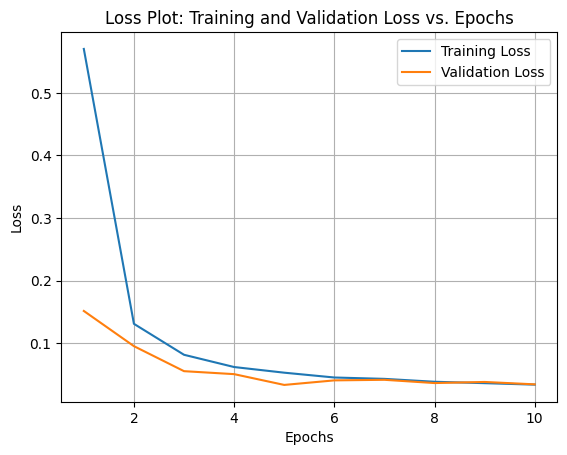

Average Test Loss: 0.0017, Test accuracy: 0.9908, Test F1 score: 0.9908


In [7]:
# 30 mins per epoch on gpu
trainer_and_validator(
    gpu='T',
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    model=bert_for_classification,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    checkpoint_dir="./checkpoints/Task1_M1/"
)

evaluator(
    gpu='T',
    checkpoint_dir="./checkpoints/Task1_M1/",
    Type='M1',
    batch_size=32, 
    test_path='./test_file.json',
    model=bert_for_classification
)

<br><br>
<h3>ERC MODEL M2</h3>

In [9]:
class GRUModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim):
        super(GRUModel, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.gru = nn.GRU(input_size=embedding_dim, hidden_size=hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
   
    def forward(self, x):
        x = x.unsqueeze(1)
        gru_output, _ = self.gru(x)
        output = self.fc(gru_output[:, -1, :])
        return output

In [14]:
embedding_dim = 300  # Dimensionality of FastText embeddings
hidden_dim = 128  # Dimensionality of hidden layer
output_dim = 7  # Number of output classes (emotions)
gru_model =GRUModel(embedding_dim, hidden_dim, output_dim)

batch_size = 32
num_epochs = 100
optimizer = AdamW(gru_model.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()

train_dataset = EmotionDataset(train_data,Type='M2')
val_dataset = EmotionDataset(val_data,Type='M2')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

/raid/home/akshat21515/.local/lib/python3.8/site-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/100, Average Training Loss: 1.6781, Train accuracy: 0.4052, Train F1 score: 0.2611 ; Average Validation Loss: 1.5697, Val accuracy: 0.4358, Val F1 score: 0.2646
Epoch 2/100, Average Training Loss: 1.5384, Train accuracy: 0.4358, Train F1 score: 0.2699 ; Average Validation Loss: 1.5167, Val accuracy: 0.4384, Val F1 score: 0.2772
Epoch 3/100, Average Training Loss: 1.4975, Train accuracy: 0.4478, Train F1 score: 0.3032 ; Average Validation Loss: 1.4800, Val accuracy: 0.4580, Val F1 score: 0.3249
Epoch 4/100, Average Training Loss: 1.4704, Train accuracy: 0.4577, Train F1 score: 0.3296 ; Average Validation Loss: 1.4581, Val accuracy: 0.4708, Val F1 score: 0.3504
Epoch 5/100, Average Training Loss: 1.4499, Train accuracy: 0.4686, Train F1 score: 0.3500 ; Average Validation Loss: 1.4403, Val accuracy: 0.4795, Val F1 score: 0.3632
Epoch 6/100, Average Training Loss: 1.4331, Train accuracy: 0.4748, Train F1 score: 0.3628 ; Average Validation Loss: 1.4245, Val accuracy: 0.4856, Val F1 

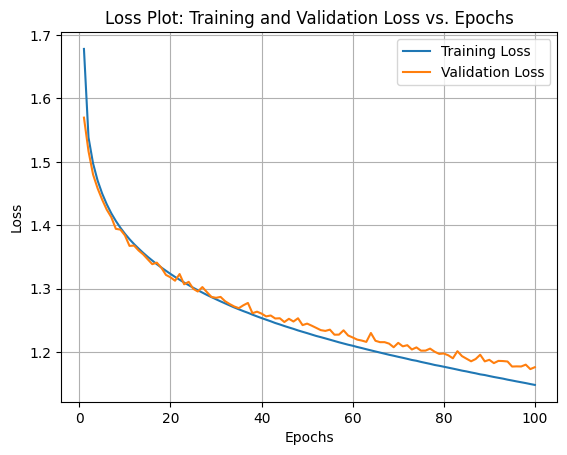

Average Test Loss: 0.0367, Test accuracy: 0.5767, Test F1 score: 0.5449


In [15]:
# 6 sec per epoch on cpu
trainer_and_validator(
    gpu='T',
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    model=gru_model,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    checkpoint_dir="./checkpoints/Task1_M2/",
    Type='M2'
)



# 1sec on cpu
evaluator(
    gpu='T',
    checkpoint_dir="./checkpoints/Task1_M2/",
    Type='M2',
    batch_size=32, 
    test_path='./test_file.json',
    model=gru_model, 
)



<br><br>
<h3>Inference File </h3>

In [12]:
# Test has 60 samples
# 6 min on cpu 
evaluator(
    gpu='T',
    checkpoint_dir="./checkpoints/Task1_M1/",
    Type='M1',
    batch_size=32,
    test_path='./test_file.json',
    model=bert_for_classification, 
    max_len=192
)



evaluator(
    gpu='T',
    checkpoint_dir="./checkpoints/Task1_M2/",
    Type='M2',
    batch_size=32, 
    test_path='./test_file.json',
    model=GRUModel(embedding_dim=300, hidden_dim=128, output_dim=7)
)



# 5 min on cpu
evaluator(
    gpu='T',
    checkpoint_dir="./checkpoints/Task2_M3/",
    Type='M3',
    batch_size=32, 
    test_path='./test_file.json',
    model=bert_for_regression, 
    max_len=112
)


evaluator(
    gpu='T',
    checkpoint_dir="./checkpoints/Task2_M4/",
    Type='M4',
    batch_size=32, 
    test_path='./test_file.json',
    model=GRUModel(embedding_dim=300*3, hidden_dim=128, output_dim=2)
)



Average Test Loss: 0.0017, Test accuracy: 0.9908, Test F1 score: 0.9908


Average Test Loss: 0.0368, Test accuracy: 0.5767, Test F1 score: 0.5449


/tmp/ipykernel_3855753/3635408986.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if (self.Type=='M3'): self.labels= torch.tensor(self.labels, dtype=torch.float) #self.labels.clone().detach().to(torch.float)


Average Test Loss: 0.0039, Test accuracy: 0.8532, Test F1 score: 0.7856


Average Test Loss: 0.0130, Test accuracy: 0.8532, Test F1 score: 0.7856


/tmp/ipykernel_3855753/3635408986.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if (self.Type=='M4'): self.labels= torch.tensor(self.labels, dtype=torch.float)
